# Generating function from equn 21 in StencilNet paper

In [1]:
import math
import numpy as np
import torch
import matplotlib.pyplot as plt 
from tqdm import tqdm
import time
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import numpy.random as npr

torch.set_default_tensor_type(torch.DoubleTensor)

Delta x =  tensor(0.0503)


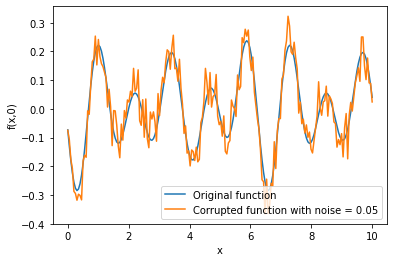

In [2]:
t = 0
N = 20
L = 2*math.pi
x = torch.linspace(0,10,200)
f = torch.tensor(0.0)
del_x = x[4]-x[3]
print("Delta x = ",del_x)

np.random.seed(0)
for i in range(1,N+1):
    A = np.random.uniform(low = -0.1, high = 0.1)
    w = np.random.uniform(low = -0.4, high = 0.4)
    phi = np.random.uniform(low = 0.0, high = 2*math.pi)
    l = np.random.choice([2,3,4,5])
    f = f + A*torch.sin(w*t + (2*math.pi*l*x)/L +phi)
    

f_noisy = f + npr.normal(0, 0.05, (200))
plt.plot(x,f,label = 'Original function')
plt.plot(x,f_noisy,label = 'Corrupted function with noise = 0.05')
plt.xlabel('x')
plt.ylabel('f(x,0)')
plt.legend()

N = f.size(0)
testPct = 0.5    #train-test split
nTrain = int(N*(1.-testPct))

train_data = f[:nTrain]
test_data = f[nTrain:]
train_data_noisy = f_noisy[:nTrain]
test_data_noisy = f_noisy[nTrain:]

In [3]:
def preprocess(data):
    inputs = torch.DoubleTensor(data.size(0)-2,2)
    outputs = torch.DoubleTensor(data.size(0)-2,1)
    inputs = inputs.cuda()
    outputs = outputs.cuda()
    inputs = torch.autograd.Variable(inputs, requires_grad=True)
    outputs = torch.autograd.Variable(outputs, requires_grad=True)
    for i in range(0, data.size(0)-2):
        inputs.data[i] = torch.DoubleTensor([data[i],data[i+2]])
        outputs.data[i] = data[i+1]
        
    return inputs,outputs

train_inputs,train_outputs = preprocess(train_data)
test_inputs,test_outputs = preprocess(test_data)
train_inputs_noisy,train_outputs_noisy = preprocess(train_data_noisy)
test_inputs_noisy,test_outputs_noisy = preprocess(test_data_noisy)
#print(test_data)
#print(test_inputs)
#print(test_outputs)

In [4]:
class Reconstruct(torch.nn.Module):
    def __init__(self,seed = 0):
        super().__init__()
        torch.manual_seed(seed)
        self.fc1=torch.nn.Linear(2,16)
        self.fc2=torch.nn.Linear(16,2)
        self.D = torch.DoubleTensor([[1,1],[del_x,((-1)*del_x)]]).to("cuda")
        self.beta = torch.DoubleTensor([1,0]).to("cuda")
        z = cp.Variable(2)
        D = cp.Parameter((2,2))
        beta = cp.Parameter(2)
        x = cp.Parameter(2)
        objective = (cp.sum_squares(z - x))     #L2 norm square used
        constraints = [D @ z == beta]
        problem = cp.Problem(cp.Minimize(objective),constraints)
        self.layer = CvxpyLayer(problem, parameters = [D,beta,x],
                      variables = [z])
        
    def forward(self,x):
        x = self.fc1(x)
        x = torch.nn.functional.elu(self.fc2(x))
        # when x is batched, repeat D and beta 
        if x.ndim == 2:
            batch_size = x.shape[0]
            return self.layer(self.D.repeat(batch_size, 1, 1), self.beta.repeat(batch_size, 1), x)[0]
        else:
            return self.layer(self.D, self.beta, x)[0]

In [5]:
def train(epoch,model,optimizer,train_inputs,train_outputs):
        
    optimizer.zero_grad()
    pred = model(train_inputs)
    loss = torch.nn.MSELoss()((pred*train_inputs).sum(1), train_outputs.flatten())
    loss.backward()
    optimizer.step()
    print('Epoch: {} \tLoss: {:.4f}'.format(epoch, loss))
    
    return loss.item()
    
def test(epoch,model,optimizer,test_inputs,test_outputs):
        
    pred = model(test_inputs)
    loss = torch.nn.MSELoss()((pred*test_inputs).sum(1), test_outputs.flatten())
        
    print('TEST SET RESULTS')
    print('Average loss: {:.4f}'.format(loss))
    
    return loss.item()

In [6]:
seed = 1

np.random.seed(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

model = Reconstruct(seed = seed)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    print(param)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Parameter containing:
tensor([[-0.6208, -0.3895],
        [-0.3758, -0.4567],
        [ 0.0793, -0.5523],
        [-0.0553,  0.2947],
        [ 0.1128, -0.0047],
        [ 0.0147, -0.2411],
        [ 0.3086, -0.1633],
        [-0.5801, -0.5410],
        [ 0.1983, -0.4288],
        [ 0.0176,  0.2996],
        [ 0.6009,  0.7067],
        [ 0.5554,  0.5328],
        [ 0.4879, -0.4887],
        [-0.4659,  0.6848],
        [ 0.4422, -0.0907],
        [-0.1212, -0.1012]], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([ 0.3645,  0.5975,  0.6567, -0.4582,  0.6419, -0.2639, -0.0645, -0.2891,
        -0.4419, -0.3631, -0.2131, -0.0791, -0.1317, -0.3027,  0.4293, -0.2521],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[-6.8049e-02, -1.0075e-01,  8.1765e-02, -1.2242e-01, -4.2814e-02,
          1.6978e-01,  1.2092e-01, -1.0675e-01,  1.4643e-01,  5.8164e-05,
          1.9887e-01, -1.9744e-01,  4.0457e-02,  2.4333e-01, -1.8424e-01,
         -1.3043e-01]

In [7]:
test_loss = []
train_loss = []
epochs = 100
start = time.time()
for epoch in tqdm(range(epochs)):
    trainloss = train(epoch,model,optimizer,train_inputs,train_outputs)
    testloss = test(epoch,model,optimizer,test_inputs,test_outputs)
    test_loss.append(testloss)
    train_loss.append(trainloss)

print ("Training time : ",time.time()-start)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Epoch: 0 	Loss: 0.0000


  1%|▊                                                                                 | 1/100 [00:03<05:50,  3.54s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 1 	Loss: 0.0000


  2%|█▋                                                                                | 2/100 [00:05<03:55,  2.40s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 2 	Loss: 0.0000


  3%|██▍                                                                               | 3/100 [00:06<03:16,  2.02s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 3 	Loss: 0.0000


  4%|███▎                                                                              | 4/100 [00:08<02:56,  1.84s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 4 	Loss: 0.0000


  5%|████                                                                              | 5/100 [00:09<02:45,  1.74s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 5 	Loss: 0.0000


  6%|████▉                                                                             | 6/100 [00:11<02:37,  1.68s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 6 	Loss: 0.0000


  7%|█████▋                                                                            | 7/100 [00:12<02:32,  1.64s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 7 	Loss: 0.0000


  8%|██████▌                                                                           | 8/100 [00:14<02:27,  1.61s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 8 	Loss: 0.0000


  9%|███████▍                                                                          | 9/100 [00:16<02:24,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 9 	Loss: 0.0000


 10%|████████                                                                         | 10/100 [00:17<02:22,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 10 	Loss: 0.0000


 11%|████████▉                                                                        | 11/100 [00:19<02:19,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 11 	Loss: 0.0000


 12%|█████████▋                                                                       | 12/100 [00:20<02:17,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 12 	Loss: 0.0000


 13%|██████████▌                                                                      | 13/100 [00:22<02:15,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 13 	Loss: 0.0000


 14%|███████████▎                                                                     | 14/100 [00:23<02:13,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 14 	Loss: 0.0000


 15%|████████████▏                                                                    | 15/100 [00:25<02:11,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 15 	Loss: 0.0000


 16%|████████████▉                                                                    | 16/100 [00:26<02:13,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 16 	Loss: 0.0000


 17%|█████████████▊                                                                   | 17/100 [00:28<02:10,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 17 	Loss: 0.0000


 18%|██████████████▌                                                                  | 18/100 [00:30<02:09,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 18 	Loss: 0.0000


 19%|███████████████▍                                                                 | 19/100 [00:31<02:09,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 19 	Loss: 0.0000


 20%|████████████████▏                                                                | 20/100 [00:33<02:08,  1.61s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 20 	Loss: 0.0000


 21%|█████████████████                                                                | 21/100 [00:34<02:06,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 21 	Loss: 0.0000


 22%|█████████████████▊                                                               | 22/100 [00:36<02:04,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 22 	Loss: 0.0000


 23%|██████████████████▋                                                              | 23/100 [00:38<02:02,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 23 	Loss: 0.0000


 24%|███████████████████▍                                                             | 24/100 [00:39<02:00,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 24 	Loss: 0.0000


 25%|████████████████████▎                                                            | 25/100 [00:41<01:58,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 25 	Loss: 0.0000


 26%|█████████████████████                                                            | 26/100 [00:42<01:56,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 26 	Loss: 0.0000


 27%|█████████████████████▊                                                           | 27/100 [00:44<01:55,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 27 	Loss: 0.0000


 28%|██████████████████████▋                                                          | 28/100 [00:46<01:53,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 28 	Loss: 0.0000


 29%|███████████████████████▍                                                         | 29/100 [00:47<01:52,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 29 	Loss: 0.0000


 30%|████████████████████████▎                                                        | 30/100 [00:49<01:50,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 30 	Loss: 0.0000


 31%|█████████████████████████                                                        | 31/100 [00:50<01:48,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 31 	Loss: 0.0000


 32%|█████████████████████████▉                                                       | 32/100 [00:52<01:46,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 32 	Loss: 0.0000


 33%|██████████████████████████▋                                                      | 33/100 [00:53<01:44,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 33 	Loss: 0.0000


 34%|███████████████████████████▌                                                     | 34/100 [00:55<01:44,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 34 	Loss: 0.0000


 35%|████████████████████████████▎                                                    | 35/100 [00:57<01:42,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 35 	Loss: 0.0000


 36%|█████████████████████████████▏                                                   | 36/100 [00:58<01:40,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 36 	Loss: 0.0000


 37%|█████████████████████████████▉                                                   | 37/100 [01:00<01:38,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 37 	Loss: 0.0000


 38%|██████████████████████████████▊                                                  | 38/100 [01:01<01:37,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 38 	Loss: 0.0000


 39%|███████████████████████████████▌                                                 | 39/100 [01:03<01:36,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 39 	Loss: 0.0000


 40%|████████████████████████████████▍                                                | 40/100 [01:04<01:34,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 40 	Loss: 0.0000


 41%|█████████████████████████████████▏                                               | 41/100 [01:06<01:32,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 41 	Loss: 0.0000


 42%|██████████████████████████████████                                               | 42/100 [01:08<01:31,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 42 	Loss: 0.0000


 43%|██████████████████████████████████▊                                              | 43/100 [01:09<01:30,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 43 	Loss: 0.0000


 44%|███████████████████████████████████▋                                             | 44/100 [01:11<01:28,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 44 	Loss: 0.0000


 45%|████████████████████████████████████▍                                            | 45/100 [01:12<01:26,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 45 	Loss: 0.0000


 46%|█████████████████████████████████████▎                                           | 46/100 [01:14<01:24,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 46 	Loss: 0.0000


 47%|██████████████████████████████████████                                           | 47/100 [01:15<01:22,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 47 	Loss: 0.0000


 48%|██████████████████████████████████████▉                                          | 48/100 [01:17<01:21,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 48 	Loss: 0.0000


 49%|███████████████████████████████████████▋                                         | 49/100 [01:18<01:19,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 49 	Loss: 0.0000


 50%|████████████████████████████████████████▌                                        | 50/100 [01:20<01:19,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 50 	Loss: 0.0000


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:22<01:18,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 51 	Loss: 0.0000


 52%|██████████████████████████████████████████                                       | 52/100 [01:23<01:16,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 52 	Loss: 0.0000


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:25<01:14,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 53 	Loss: 0.0000


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:26<01:12,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 54 	Loss: 0.0000


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:28<01:10,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 55 	Loss: 0.0000


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:30<01:08,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 56 	Loss: 0.0000


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:31<01:07,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 57 	Loss: 0.0000


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:33<01:06,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 58 	Loss: 0.0000


 59%|███████████████████████████████████████████████▊                                 | 59/100 [01:34<01:04,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 59 	Loss: 0.0000


 60%|████████████████████████████████████████████████▌                                | 60/100 [01:36<01:02,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 60 	Loss: 0.0000


 61%|█████████████████████████████████████████████████▍                               | 61/100 [01:37<01:01,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 61 	Loss: 0.0000


 62%|██████████████████████████████████████████████████▏                              | 62/100 [01:39<00:59,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 62 	Loss: 0.0000


 63%|███████████████████████████████████████████████████                              | 63/100 [01:41<00:58,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 63 	Loss: 0.0000


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:42<00:56,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 64 	Loss: 0.0000


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:44<00:55,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 65 	Loss: 0.0000


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:45<00:54,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 66 	Loss: 0.0000


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:47<00:52,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 67 	Loss: 0.0000


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:48<00:50,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 68 	Loss: 0.0000


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:50<00:49,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 69 	Loss: 0.0000


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:52<00:47,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 70 	Loss: 0.0000


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:53<00:45,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 71 	Loss: 0.0000


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:55<00:44,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 72 	Loss: 0.0000


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:56<00:42,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 73 	Loss: 0.0000


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:58<00:41,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 74 	Loss: 0.0000


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:00<00:39,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 75 	Loss: 0.0000


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:01<00:38,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 76 	Loss: 0.0000


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:03<00:36,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 77 	Loss: 0.0000


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:04<00:34,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 78 	Loss: 0.0000


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:06<00:33,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 79 	Loss: 0.0000


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:08<00:32,  1.60s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 80 	Loss: 0.0000


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:09<00:30,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 81 	Loss: 0.0000


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:11<00:28,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 82 	Loss: 0.0000


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:12<00:26,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 83 	Loss: 0.0000


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:14<00:25,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 84 	Loss: 0.0000


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:15<00:23,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 85 	Loss: 0.0000


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:17<00:21,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 86 	Loss: 0.0000


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [02:19<00:20,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 87 	Loss: 0.0000


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [02:20<00:18,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 88 	Loss: 0.0000


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [02:22<00:17,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 89 	Loss: 0.0000


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [02:23<00:15,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 90 	Loss: 0.0000


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [02:25<00:14,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 91 	Loss: 0.0000


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [02:26<00:12,  1.55s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 92 	Loss: 0.0000


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [02:28<00:10,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 93 	Loss: 0.0000


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [02:30<00:09,  1.58s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 94 	Loss: 0.0000


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [02:31<00:07,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 95 	Loss: 0.0000


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [02:33<00:06,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 96 	Loss: 0.0000


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [02:34<00:04,  1.56s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 97 	Loss: 0.0000


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [02:36<00:03,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 98 	Loss: 0.0000


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [02:37<00:01,  1.57s/it]

TEST SET RESULTS
Average loss: 0.0000
Epoch: 99 	Loss: 0.0000


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]

TEST SET RESULTS
Average loss: 0.0000
Training time :  159.41748476028442


Training time is 155.3 s
Test loss after 100 epochs: 1.3154262899296042e-05
Training loss after 100 epochs: 1.1943819581330051e-05


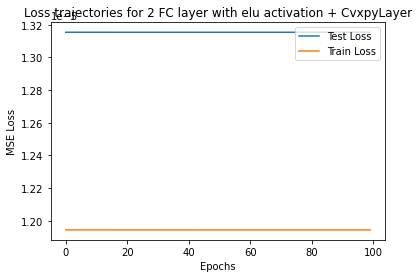

In [8]:
plt.plot(torch.DoubleTensor(test_loss),label = "Test Loss")
plt.plot(torch.DoubleTensor(train_loss),label = "Train Loss")
plt.legend(loc = "upper right")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Loss trajectories for 2 FC layer with elu activation + CvxpyLayer")
print("Training time is 155.3 s")
print("Test loss after 100 epochs:",test_loss[-1])
print("Training loss after 100 epochs:",train_loss[-1])

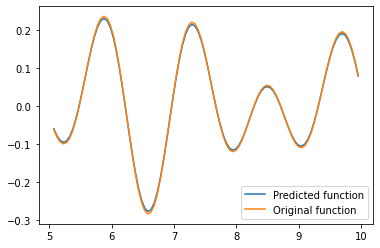

In [9]:
pred = model(test_inputs)
pred = pred.cpu().detach().numpy()
#test_inputs_noisy = test_inputs_noisy.to('cpu').detach().numpy()
test_inputs = test_inputs.to('cpu').detach().numpy()
test_outputs = test_outputs.to('cpu').detach().numpy()
#test_outputs_noisy = test_outputs_noisy.to('cpu').detach().numpy()
#print(pred)
plt.plot(x[-99:-1],(pred*test_inputs).sum(1),label = 'Predicted function')
plt.plot(x[-99:-1],test_outputs.flatten(),label = 'Original function')
#plt.plot(x[-99:-1],test_outputs_noisy.flatten(),label = 'Corrupted function with 0.05 noise')
plt.legend()

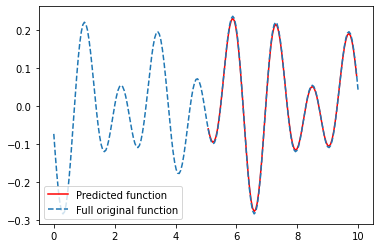

In [10]:
plt.plot(x[-99:-1],(pred*test_inputs).sum(1),label = 'Predicted function',color = 'red')
#plt.plot(x[-99:-1],test_outputs.flatten(),label = 'Original function given',color = 'red')
plt.plot(x,f,label = 'Full original function',linestyle = 'dashed')
plt.legend()

Text(0.5, 1.0, 'Visualising predicted coefficients for 2 FC layers with moment constraints without noise')

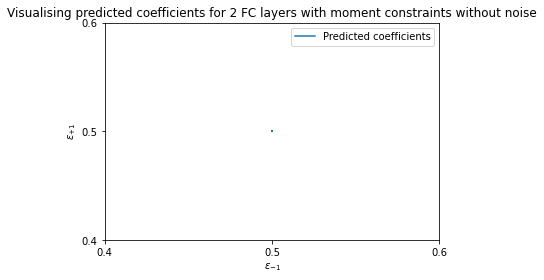

In [22]:
plt.plot(pred[:,0],pred[:,1],label = 'Predicted coefficients')
plt.legend()
plt.yticks([0.4,0.5,0.6])
plt.xticks([0.4,0.5,0.6])
plt.xlabel('$\epsilon_{-1}$')
plt.ylabel('$\epsilon_{+1}$')
plt.title("Visualising predicted coefficients for 2 FC layers with moment constraints without noise")

Text(0.5, 1.0, 'Sum of predicted coefficients for 2 FC layers with moment constraints without noise')

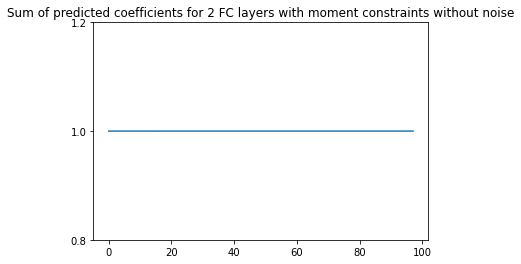

In [25]:
plt.plot(pred[:,0]+pred[:,1])
plt.yticks([0.8,1.0,1.2])
plt.title("Sum of predicted coefficients for 2 FC layers with moment constraints without noise")

In [13]:
f = open("Predicted_coefficients_test_set_noisy.txt",'w')
for i in pred:
    print(i)
    f.write(str(i) + "\n")
f.close()

[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.49999963 0.49999963]
[0.4999992 0.4999992]
[0.49999923 0.49999923]
[0.49999919 0.49999919]
[0.50000001 0.50000001]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.49999963 0.49999963]
[0.49999915 0.49999915]
[0.49999925 0.49999925]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
